In [1]:
%pip install river pandas==2.2.2 scipy==1.13.1 numpy==1.26.1


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install matplotlib yfinance matplotlib yfinance numpy scikit-learn river scikit-optimize pysqlite3


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
from sklearn.model_selection import train_test_split
from river import metrics, preprocessing
from classes.superclasse.ModeloBase import ModeloBase

from skopt.space import Real, Integer, Categorical
from classes.otimizador.OtimizadorBayesiano import OtimizadorBayesiano

# 1.Baixar Dados

A função `baixar_dados` baixa os dados históricos de uma ação do Yahoo Finance, permitindo ajustar o período e o intervalo dos dados.

In [4]:
# Função para baixar dados do Yahoo Finance
def baixar_dados(symbol, periodo="5y", intervalo="1d"):
    data = yf.download(symbol, period=periodo, interval=intervalo)
    return data["Close"].values

## 2. Criar Janelas Temporais e Normalizar Dados
A função `criar_janela_temporal` cria as janelas de entrada e saída para o modelo de previsão. As entradas são geradas com base no número de `lags` definido e as saídas são os valores de fechamento seguintes. A função `Normalizar` transforma os dados para o intervalo de 0 e 1.

In [5]:
# Função para criar padrões de entrada e saída
def criar_janela_temporal(y, lags):
    X, Y = [], []
    for i in range(len(y) - lags):
        X.append(y[i:i+lags])
        Y.append(y[i+lags])
    return np.array(X).reshape(-1, lags), np.array(Y)

In [6]:
def normalizar_serie(serie_temporal: np.ndarray) -> np.ndarray:
    # Criando o scaler
    scaler = preprocessing.StandardScaler()

    # Aprendendo a escala com os dados
    for x in serie_temporal:
        scaler.learn_one({"valor": x[0]})  # Não sobrescrevemos o scaler

    # Transformando a série
    serie_normalizada = np.array([scaler.transform_one({"valor": x[0]})["valor"] for x in serie_temporal])

    # Garantindo que o shape permaneça (1244, 1)
    return serie_normalizada.reshape(-1, 1)

# 3.Inicializar Modelos

In [7]:
def inicializar_modelos(modelo_classe, detector_classe, **kwargs):

     # Instancia o modelo com os parâmetros fornecidos
     modelo_instancia = modelo_classe(**kwargs)

     # Instancia o detector com os parâmetros fornecidos
     detector_instancia = detector_classe(**kwargs)

     return modelo_instancia, detector_instancia

## 4. Treinamento do Modelo de Machine Learning
A função `treinamento_modelo` realiza o treinamento inicial do modelo com os primeiros dados disponíveis, usando o tamanho do batch especificado.

In [8]:
def treinamento_modelo_batch(modelo, X, y):
    # Treinamento do modelo usando o método 'treinar' da subclasse
    modelo.treinar(X, y)

    # Cálculo do erro médio (adapte para modelos online, se necessário)

    if isinstance(modelo, ModeloBase):  # Verifica se é uma instância da superclasse dos modelos offline
      erro_medio = np.abs(np.mean(y - modelo.prever(X))) # Calcula erro para modelos offline

    else: # Senão calcula para modelos online
      predicoes = []
      for i in range(len(X)):
          predicoes.append(modelo.prever(X[i].reshape(1, -1))[0]) # Faz as predições para cada exemplo em X
      erro_medio = np.abs(np.mean(y.ravel() - np.array(predicoes))) # Calcula o erro médio

    return erro_medio

In [9]:
def treinamento_online_many(modelo, X, y, tamanho_batch):  # Adiciona 'tamanho_batch' como parâmetro
    # Treina o modelo com os primeiros 'tamanho_batch' exemplos
    modelo.treinar(X[:tamanho_batch], y[:tamanho_batch])
    return modelo

In [10]:
def prequential_batch(X, Y, tamanho_batch, modelo_classe, detector_classe, **kwargs):
    """
    Realiza a previsão de valores continuamente, detectando mudanças nos dados (drift)
    e retreinando o modelo quando necessário.

    Args:
        X: Dados de entrada.
        Y: Dados de saída.
        tamanho_batch: Tamanho do batch para treinamento inicial e retreinamento.
        modelo_classe: Classe do modelo a ser usado (subclasse de ModeloBase).
        detector_classe: Classe do detector de drift a ser usado (subclasse de DetectorDriftBase).
        **kwargs: Parâmetros adicionais para o modelo e detector.

    Returns:
        predicoes: Lista de previsões.
        deteccoes: Lista de índices onde o drift foi detectado.
    """
    predicoes, erros, deteccoes = [], [], []
    mae = metrics.MAE()

    # Inicializando o modelo e o detector usando as classes
    modelo, detector = inicializar_modelos(modelo_classe, detector_classe, **kwargs)

    # Treina o modelo e atualiza o detector
    erro_inicial = treinamento_modelo_batch(modelo, X[:tamanho_batch], Y[:tamanho_batch])
    detector.atualizar(erro_inicial)  # Usa o método 'atualizar' da subclasse

    drift_ativo = False

    for i in range(tamanho_batch, len(X)):
        # Realiza a predição usando o método 'prever' da subclasse
        entrada = X[i].reshape(1, -1)
        y_pred = modelo.prever(entrada)[0]
        erro = abs(Y[i][0] - y_pred)

        predicoes.append(y_pred)
        erros.append(erro)
        mae.update(Y[i][0], y_pred)

        # Atualiza o detector usando o método 'atualizar' da subclasse
        detector.atualizar(erro)

        # Se drift for detectado pela primeira vez
        if detector.drift_detectado and not drift_ativo:  # Usa a propriedade 'drift_detectado'
            deteccoes.append(i)
            print(f"\nMudança detectada no índice {i}, começando a coletar dados para retreino...")
            drift_ativo = True
            janela_X, janela_y = [], []

        # Se drift já foi detectado, inicia-se a coleta dos dados
        if drift_ativo:
            janela_X.append(X[i])
            janela_y.append(Y[i])

            if len(janela_X) >= tamanho_batch:
                print(f"Janela completa com {len(janela_X)} amostras. Retreinado com dados do índice {i - tamanho_batch} até {i}.")
                drift_ativo = False

                # Inicializando o modelo e o detector com novas instâncias
                modelo, detector = inicializar_modelos(modelo_classe, detector_classe, **kwargs)

                # Treina o modelo e atualiza o detector
                erro_inicial = treinamento_modelo_batch(modelo, np.array(janela_X), np.array(janela_y))
                detector.atualizar(erro_inicial)  # Usa o método 'atualizar' da subclasse

    # Calculando o desvio padrão dos erros com NumPy
    desvio_padrao = np.std(erros)

    print("Modelo utilizado:", modelo)
    print("Detector utilizado:", detector)
    print(f"MAE Modelo Batch: {mae.get()}")
    print(f"Desvio Padrão dos Erros: {desvio_padrao}")

    return predicoes, deteccoes

In [11]:
def prequential_passivo(X, Y, tamanho_batch, modelo_classe, **kwargs):
    """
    Realiza a previsão de valores continuamente para algoritmos online,
    sem detecção de drift e retreinamento.

    Args:
        X: Dados de entrada.
        Y: Dados de saída.
        tamanho_batch: Tamanho do batch para treinamento inicial.
        modelo_classe: Classe do modelo a ser usado (subclasse de ModeloBase).
        **kwargs: Parâmetros adicionais para o modelo.

    Returns:
        predicoes: Lista de previsões.
    """
    predicoes = []
    mae = metrics.MAE()

    # Inicializa o modelo usando a classe e kwargs
    modelo = modelo_classe(**kwargs)

    # Treina o modelo com os primeiros exemplos usando treinamento_online_many
    modelo = treinamento_online_many(modelo, X, Y, tamanho_batch)

    for i in range(tamanho_batch, len(X)):
        # Converte a entrada para o formato que o modelo online espera
        entrada_dict = {f"t{j+1}": value for j, value in enumerate(X[i])}

        # Realiza a predição usando o método 'prever' da subclasse
        y_pred = modelo.prever([X[i]])  # Passa a entrada como uma lista de uma única amostra

        predicoes.append(y_pred)
        mae.update(Y[i][0], y_pred)

        # Atualiza o modelo online usando o método 'treinar' da subclasse
        modelo.treinar([X[i]], [Y[i]])

    print("Modelo utilizado:", modelo)
    print(f"MAE Modelo Online: {mae.get()}")
    return predicoes

In [ ]:
def definir_espacos_parametros():
    """
    Define os espaços de parâmetros para cada modelo

    Retorna:
    --------
    espacos : dict
        Dicionário com espaços de parâmetros para cada modelo
    """
    espacos = {
        # Modelos offline (scikit-learn)
        "LinearRegressionModelo": {
            'fit_intercept': Categorical([True, False]),
            'copy_X': Categorical([True, False]),
            # Remover 'normalize'
            'positive': Categorical([True, False])
        },
        "KNeighborsRegressorModelo": {
            "n_neighbors": Integer(1, 20),
            "weights": Categorical(['uniform', 'distance']),
            "p": Integer(1, 2)
        },
        "LassoRegressionModelo": {
            "alpha": Real(0.001, 10.0, prior='log-uniform'),
            "max_iter": Integer(100, 2000),
            "tol": Real(1e-6, 1e-2, prior='log-uniform')
        },
        "MLPRegressorModelo": {
            "hidden_layer_sizes": Categorical([(50,), (100,), (50, 50), (100, 50)]),
            "activation": Categorical(['relu', 'tanh']),
            "solver": Categorical(['adam', 'sgd']),
            "alpha": Real(1e-5, 1e-2, prior='log-uniform'),
            "learning_rate_init": Real(1e-4, 1e-1, prior='log-uniform')
        },
        "RandomForestModelo": {
            "n_estimators": Integer(50, 200),
            "max_depth": Integer(5, 30),
            "min_samples_split": Integer(2, 10),
            "min_samples_leaf": Integer(1, 4)
        },
        "RidgeRegressionModelo": {
            "alpha": Real(0.01, 10.0, prior='log-uniform'),
            "solver": Categorical(['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'])
        },
        "SVRModelo": {
            "C": Real(0.1, 100, prior='log-uniform'),
            "epsilon": Real(0.01, 1.0, prior='log-uniform'),
            "kernel": Categorical(['linear', 'rbf', 'poly']),
            "gamma": Real(1e-3, 1, prior='log-uniform')
        },

        # Modelos online (River)
        "HoeffdingTreeModelo": {
            "grace_period": Integer(50, 200),
            "split_confidence": Real(1e-10, 1e-1, prior='log-uniform'),
            "leaf_prediction": Categorical(['mean', 'model'])
        },
        "SGDModelo": {
            "loss": Categorical(['squared_error', 'absolute_error']),
            "learning_rate": Real(0.001, 0.1, prior='log-uniform'),
            "l2": Real(0.0, 0.1)
        },
        "LinearRegressionRiverModelo": {
            "optimizer_lr": Real(0.001, 0.1, prior='log-uniform'),
            "l2": Real(0.0, 0.1)
        },
        "PARegressorModelo": {
            "C": Real(0.01, 10.0, prior='log-uniform'),
            "mode": Integer(0, 2)
        }
    }

    return espacos

In [13]:
# Função principal para otimizar todos os modelos
# TODO: Verificar se realmente funciona, caso não, apague.
def otimizar_todos_modelos(X, Y, tamanho_batch, lags, modelos_offline=None, modelos_online=None):
    """
    Otimiza todos os modelos especificados e retorna os modelos otimizados

    Parâmetros:
    -----------
    X : array-like
        Dados de entrada
    Y : array-like
        Dados alvo
    tamanho_batch : int
        Tamanho do batch para avaliação prequential
    lags : int
        Número de lags na série temporal
    modelos_offline : list, opcional
        Lista de classes de modelos offline para otimizar
    modelos_online : list, opcional
        Lista de classes de modelos online para otimizar

    Retorna:
    --------
    modelos_otimizados : dict
        Dicionário com modelos otimizados
    parametros_otimizados : dict
        Dicionário com parâmetros otimizados para cada modelo
    """
    optimizer = OtimizadorBayesiano(n_iter=20, cv=3, random_state=42)
    espacos = definir_espacos_parametros()

    modelos_otimizados = {}
    parametros_otimizados = {}

    # Otimizar modelos offline (scikit-learn)
    if modelos_offline:
        for modelo_classe in modelos_offline:
            nome_modelo = modelo_classe.__name__
            if nome_modelo in espacos:
                print(f"\nOtimizando {nome_modelo}...")
                modelo_otimizado, params = optimizer.otimizar_offline(
                    modelo_classe,
                    espacos[nome_modelo],
                    X, Y
                )
                modelos_otimizados[nome_modelo] = modelo_otimizado
                parametros_otimizados[nome_modelo] = params
            else:
                print(f"Espaço de parâmetros não definido para {nome_modelo}")

    # Otimizar modelos online (River)
    if modelos_online:
        for modelo_classe in modelos_online:
            nome_modelo = modelo_classe.__name__
            if nome_modelo in espacos:
                print(f"\nOtimizando {nome_modelo}...")
                modelo_otimizado, params = optimizer.otimizar_online(
                    modelo_classe,
                    espacos[nome_modelo],
                    X, Y,
                    tamanho_batch
                )
                modelos_otimizados[nome_modelo] = modelo_otimizado
                parametros_otimizados[nome_modelo] = params
            else:
                print(f"Espaço de parâmetros não definido para {nome_modelo}")

    return modelos_otimizados, parametros_otimizados

# Plot

In [ ]:
def plotar_resultados(Y, lista_predicoes, labels_algoritmos, deteccoes_por_modelo, tamanho_batch):
    plt.figure(figsize=(15, 8))
    indices = range(tamanho_batch, tamanho_batch + len(Y[tamanho_batch:]))

    # Plotar valores verdadeiros
    plt.plot(indices, Y[tamanho_batch:tamanho_batch + len(indices)],
             label="Verdadeiro", linewidth=1.2, color='black')

    # Plotar cada conjunto de previsões
    for i, predicoes in enumerate(lista_predicoes):
        Y_plot = Y[tamanho_batch:tamanho_batch + len(predicoes)]
        predicoes = predicoes[:len(Y_plot)]  # Garantir mesmo tamanho
        label = labels_algoritmos[i] if i < len(labels_algoritmos) else f"Previsões {i+1}"
        plt.plot(indices[:len(predicoes)], predicoes, label=label, linewidth=1.2)

        # Obter detecções para este modelo (se disponíveis)
        modelo_deteccoes = deteccoes_por_modelo[i] if i < len(deteccoes_por_modelo) else []

        # Aumentar o tamanho dos pontos de detecção para este modelo
        if modelo_deteccoes:
            # Verificar se cada ponto de detecção está nos índices válidos
            valid_deteccoes = [d for d in modelo_deteccoes if d < len(Y)]

            if valid_deteccoes:
                # Usar uma cor diferente para cada modelo
                cor = plt.cm.tab10(i / 10) if i < 10 else plt.cm.Set3((i-10) / 10)

                plt.scatter(valid_deteccoes, [Y[d] for d in valid_deteccoes],
                           color=cor, marker='o',
                           label=f"Drift - {label}", zorder=3, s=80)

                # Destacar áreas pós-retreino com fundo colorido
                for idx, d in enumerate(valid_deteccoes):
                    if d + tamanho_batch < len(indices):
                        next_end = min(d + tamanho_batch, indices[-1])
                        plt.axvspan(d, next_end, alpha=0.1, color=cor, label='_nolegend_')

                # Adicionar anotações para mostrar diferenças
                for d in valid_deteccoes[:3]:  # Limitar a 3 anotações por modelo para não sobrecarregar
                    if d + 5 < len(indices):
                        plt.annotate(f"Retreino {label}",
                                    xy=(d, Y[d]),
                                    xytext=(d+10, Y[d]+0.1 * (i+1)),  # Deslocar verticalmente
                                    arrowprops=dict(facecolor=cor, shrink=0.05, width=1.5),
                                    fontsize=9,
                                    color=cor)

                print(f"\nDrift detectado para {label} nos índices:", valid_deteccoes)
            else:
                print(f"\nNenhum drift válido detectado para {label}.")
        else:
            print(f"\nNenhum drift detectado para {label}.")

    plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    plt.title("Predições e Detecção de Drift com Retreino", fontsize=14)
    plt.grid(True, alpha=0.4)
    plt.tight_layout()

    plt.show()

# Execução dos experimentos

In [15]:
series = [
    "AAPL",
    "B3SA3.SA"
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

In [16]:
from classes.detectores.ADWINDetector import ADWINDetector
from classes.detectores.DDMDetector import DDMDetector
from classes.detectores.EDDMDetector import EDDMDetector
from classes.detectores.FHDDMDetector import FHDDMDetector
from classes.detectores.HDDM_ADetector import HDDM_ADetector
from classes.detectores.PageHinkleyDetector import PageHinkleyDetector
from classes.detectores.HDDM_WDetector import HDDM_WDetector
#from classes.detectores.KSWINDetector import KSWINDetector

from classes.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from classes.modelosOffline.KneighborsRegressorModelo import KNeighborsRegressorModelo
from classes.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from classes.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from classes.modelosOffline.SVRModelo import SVRModelo
from classes.modelosOffline.RandomForestModelo import RandomForestModelo
from classes.modelosOffline.MLPRegressorModelo import MLPRegressorModelo

from classes.modelosOnline.BayesianLinearRegressionModelo import BayesianLinearRegressionModelo
from classes.modelosOnline.HoeffdingTreeRegressorModelo import HoeffdingTreeRegressorModelo
from classes.modelosOnline.KNNRegressorOnlineModelo import KNNRegressorOnlineModelo
from classes.modelosOnline.LinearRegressionOnlineModelo import LinearRegressionOnlineModelo

[*********************100%***********************]  1 of 1 completed



Otimizando LinearRegressionModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [False, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, False] before, using random point [True, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [True, False, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, False] before, using random point [True, True, True]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [False, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, False, True] before, using random point [True, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, True, False] before, using random point [False, False, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [False, False, False] before, using random point [True, False, True]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [True, True, False] before, using random point [True, True, False]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits

Otimizando KNeighborsRegressorModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.839e-01, tolerance: 5.547e-04
  model = cd_fast.enet_coordinate_descent(
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e+00, tolerance: 9.772e-04
  model = cd_fast.enet_coordinate_descent(
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Otimizando RandomForestModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector 


Otimizando RidgeRegressionModelo...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v

Espaço de parâmetros não definido para BayesianLinearRegressionModelo
Espaço de parâmetros não definido para HoeffdingTreeRegressorModelo
Espaço de parâmetros não definido para KNNRegressorOnlineModelo
Espaço de parâmetros não definido para LinearRegressionOnlineModelo
Parâmetros otimizados salvos em 'parametros_otimizados.json'
Executando prequential para LinearRegressionModelo...
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x747230f98e30>
MAE Modelo Batch: [0.09400235]
Desvio Padrão dos Erros: 0.07537817656533789
Executando prequential para KNeighborsRegressorModelo...

Mudança detectada no índice 208, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 207 até 257.

Mudança detectada no índice 448, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 447 até 497.

Mudança detectada no índice 656, com

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 208, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 207 até 257.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 512, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 511 até 561.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 848, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 847 até 897.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x747227db62a0>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x747227e03b30>
MAE Modelo Batch: 0.46930906930154476
Desvio Padrão dos Erros: 0.5033689588742095
Executando prequential para RidgeRegressionModelo...
Modelo utilizado: <classes.modelosOffline.RidgeRegressionModelo.RidgeRegressionModelo object at 0x7472337dea50>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x747233599160>
MAE Modelo Batch: 0.10096481687933662
Desvio Padrão dos Erros: 0.0773848578859626
Executando prequential para SVRModelo...


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v


Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.

Mudança detectada no índice 448, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 447 até 497.

Mudança detectada no índice 656, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 655 até 705.

Mudança detectada no índice 928, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 927 até 977.
Modelo utilizado: <classes.modelosOffline.SVRModelo.SVRModelo object at 0x7472273a7cb0>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x747230f961e0>
MAE Modelo Batch: 0.6606719580598606
Desvio Padrão dos Erros: 0.68639582618438

Nenhum drift detectado para LinearRegressionModelo.

Drift detectado para KNeighborsRegressorModelo nos índices: [208, 448

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


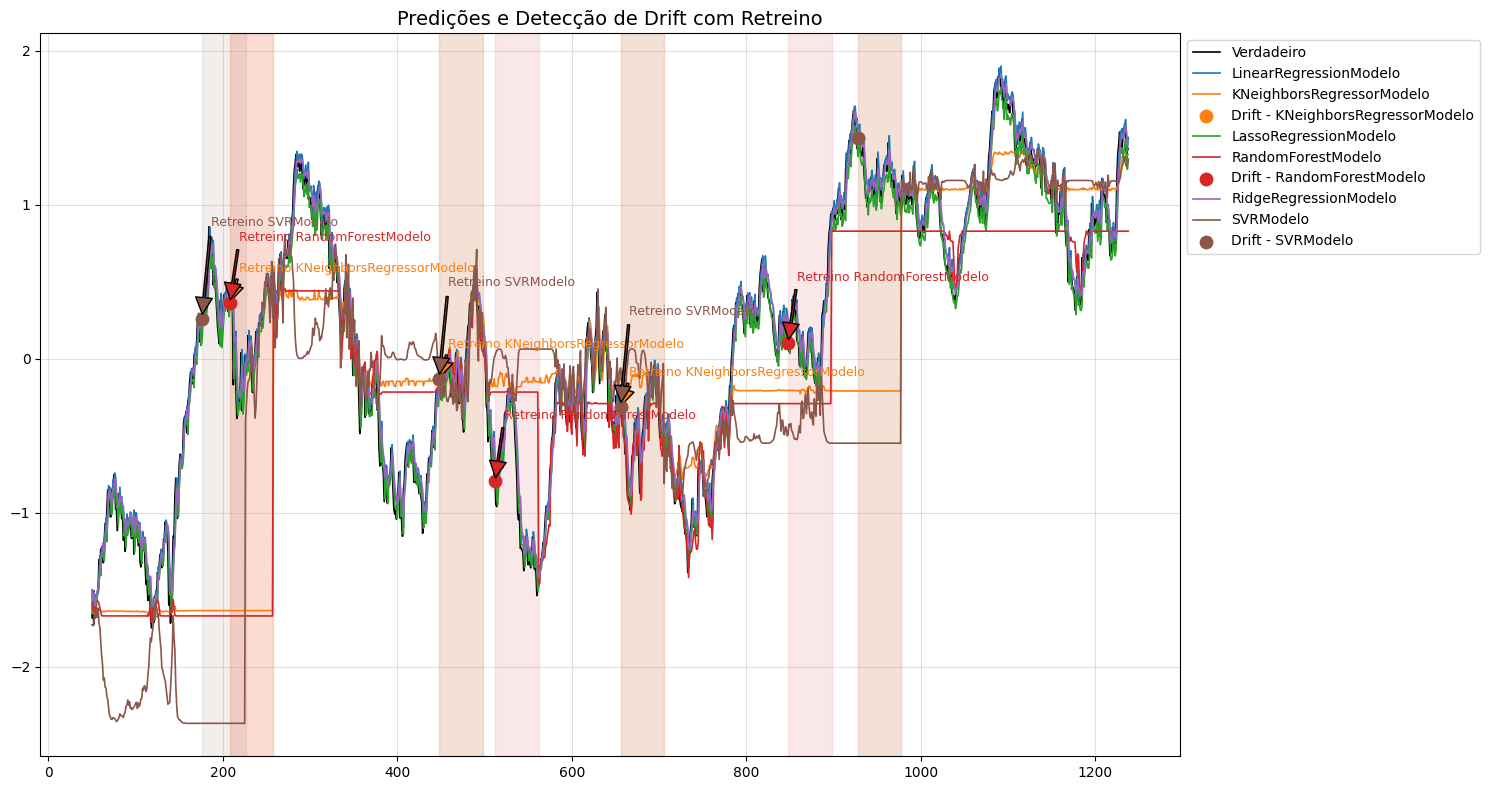

In [22]:
# Baixando os dados da ação
serie_temporal = baixar_dados(series[-2])

# Normalizando a série temporal
serie_temporal = normalizar_serie(serie_temporal)

# Gerando janelas temporais
X, Y = criar_janela_temporal(serie_temporal, lags=5)

# Definindo tamanho do batch
tamanho_batch = 50

# Lista de modelos a otimizar (instâncias)
# Lista de modelos a otimizar (classes)
modelos_offline = [
    LinearRegressionModelo,
    KNeighborsRegressorModelo,
    LassoRegressionModelo,
    #MLPRegressorModelo,
    RandomForestModelo,
    RidgeRegressionModelo,
    SVRModelo
]

modelos_online = [
    BayesianLinearRegressionModelo,
    HoeffdingTreeRegressorModelo,
    KNNRegressorOnlineModelo,
    LinearRegressionOnlineModelo
]

# Otimizando todos os modelos
modelos_otimizados, parametros_otimizados = otimizar_todos_modelos(
    X, Y, tamanho_batch, lags=5,
    modelos_offline=modelos_offline,
    modelos_online=modelos_online
)

# Salvar parâmetros otimizados para uso futuro
import json
with open('parametros_otimizados.json', 'w') as f:
    # Converter valores não serializáveis para strings
    params_serializaveis = {}
    for modelo, params in parametros_otimizados.items():
        params_serializaveis[modelo] = {k: str(v) for k, v in params.items()}
    json.dump(params_serializaveis, f, indent=4)

print("Parâmetros otimizados salvos em 'parametros_otimizados.json'")

# Executando prequential com os modelos otimizados
resultados = {}
deteccoes_por_modelo = {}  # Novo dicionário para armazenar as detecções

for nome_modelo, modelo in modelos_otimizados.items():
    print(f"Executando prequential para {nome_modelo}...")
    predicoes, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=type(modelo), detector_classe=ADWINDetector)
    resultados[nome_modelo] = predicoes
    deteccoes_por_modelo[nome_modelo] = deteccoes  # Armazena as detecções

# Plotando os resultados
plotar_resultados(Y,
                  list(resultados.values()),
                  list(resultados.keys()),
                  list(deteccoes_por_modelo.values()),  # Passa as detecções para cada modelo
                  tamanho_batch)

In [ ]:
# Função atualizada para plotar resultados com múltiplas detecções
def plotar_resultados_multi(Y, lista_predicoes, labels_algoritmos, deteccoes_dict, tamanho_batch):
    plt.figure(figsize=(15, 8))
    indices = range(tamanho_batch, tamanho_batch + len(Y[tamanho_batch:]))

    # Plotar valores verdadeiros
    plt.plot(indices, Y[tamanho_batch:tamanho_batch + len(indices)],
             label="Verdadeiro", linewidth=1.2, color='black')

    # Plotar cada conjunto de previsões
    for i, predicoes in enumerate(lista_predicoes):
        if i >= len(labels_algoritmos):
            continue

        modelo_nome = labels_algoritmos[i]
        Y_plot = Y[tamanho_batch:tamanho_batch + len(predicoes)]
        predicoes = predicoes[:len(Y_plot)]  # Garantir mesmo tamanho

        # Cor para este modelo
        cor = plt.cm.tab10(i / 10) if i < 10 else plt.cm.Set3((i-10) / 10)

        plt.plot(indices[:len(predicoes)], predicoes, label=modelo_nome, linewidth=1.2, color=cor)

        # Obter detecções para este modelo
        if modelo_nome in deteccoes_dict:
            modelo_deteccoes = deteccoes_dict[modelo_nome]

            if modelo_deteccoes:
                # Filtrar detecções válidas
                valid_deteccoes = [d for d in modelo_deteccoes if d < len(Y)]

                if valid_deteccoes:
                    plt.scatter(valid_deteccoes, [Y[d] for d in valid_deteccoes],
                              color=cor, marker='o', s=60,
                              label=f"Drift - {modelo_nome}", zorder=3)

                    # Destacar áreas pós-retreino
                    for d in valid_deteccoes:
                        if d + tamanho_batch < len(indices):
                            next_end = min(d + tamanho_batch, indices[-1])
                            plt.axvspan(d, next_end, alpha=0.1, color=cor, label='_nolegend_')

                    print(f"\nDrift detectado para {modelo_nome} nos índices:", valid_deteccoes)
                else:
                    print(f"\nNenhum drift válido detectado para {modelo_nome}.")
            else:
                print(f"\nNenhum drift detectado para {modelo_nome}.")

    plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    plt.title("Predições e Detecção de Drift com Retreino", fontsize=14)
    plt.grid(True, alpha=0.4)
    plt.tight_layout()

    plt.show()

[*********************100%***********************]  1 of 1 completed


<class 'classes.modelosOffline.LinearRegressionModelo.LinearRegressionModelo'>
Modelo utilizado: LinearRegressionModelo()
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7472273c7f20>
MAE Modelo Batch: [0.08795493]
Desvio Padrão dos Erros: 0.06979368427878441

Mudança detectada no índice 208, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 207 até 257.

Mudança detectada no índice 448, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 447 até 497.

Mudança detectada no índice 656, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 655 até 705.

Mudança detectada no índice 928, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 927 até 977.
Modelo utilizado: <classes.modelosOffline.KneighborsRegressorModelo.KNeighborsRegressorModel

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Mudança detectada no índice 912, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 911 até 961.
Modelo utilizado: <classes.modelosOffline.MLPRegressorModelo.MLPRegressorModelo object at 0x747230f9af60>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7472245dd130>
MAE Modelo Batch: 0.4711907290238896
Desvio Padrão dos Erros: 0.39700008664381087


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 208, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 207 até 257.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 512, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 511 até 561.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 848, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 847 até 897.


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x7472310efcb0>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7472245fa9c0>
MAE Modelo Batch: 0.4777315061116741
Desvio Padrão dos Erros: 0.516197262085348
Modelo utilizado: <classes.modelosOffline.RidgeRegressionModelo.RidgeRegressionModelo object at 0x7472246fea20>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x7472246ffcb0>
MAE Modelo Batch: 0.09776380803796157
Desvio Padrão dos Erros: 0.07491304030565166


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-v


Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.

Mudança detectada no índice 448, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 447 até 497.

Mudança detectada no índice 656, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 655 até 705.

Mudança detectada no índice 928, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 927 até 977.
Modelo utilizado: <classes.modelosOffline.SVRModelo.SVRModelo object at 0x7472246fecc0>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x747230f90530>
MAE Modelo Batch: 0.6604715059738603
Desvio Padrão dos Erros: 0.6834239320020338


/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TypeError: 'int' object is not iterable

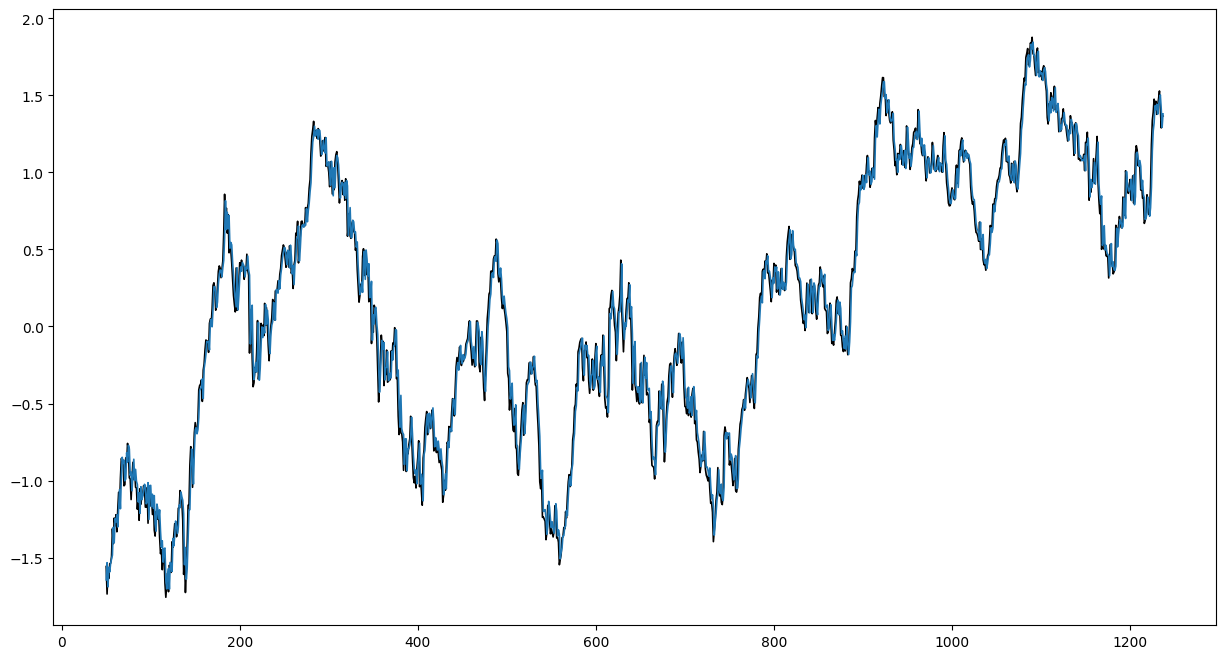

In [26]:
tamanho_batch, lags = 50, 5

# Baixando os dados da ação
serie_temporal = baixar_dados(series[-2])

# normalizando a série temporal
serie_temporal = normalizar_serie(serie_temporal)

# Gerando janelas temporais
X, Y = criar_janela_temporal(serie_temporal, lags)

print(LinearRegressionModelo)

# Prequential com detecção de drift (usando classes)
predicoes_ativa1, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=LinearRegressionModelo, detector_classe=ADWINDetector)
predicoes_ativa2, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=KNeighborsRegressorModelo, detector_classe=ADWINDetector)
predicoes_ativa3, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=LassoRegressionModelo, detector_classe=ADWINDetector)
predicoes_ativa4, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=MLPRegressorModelo, detector_classe=ADWINDetector)
predicoes_ativa5, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=RandomForestModelo, detector_classe=ADWINDetector)
predicoes_ativa6, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=RidgeRegressionModelo, detector_classe=ADWINDetector)
predicoes_ativa7, deteccoes = prequential_batch(X, Y, tamanho_batch, modelo_classe=SVRModelo, detector_classe=ADWINDetector)


# Plotando os resultados
plotar_resultados(Y, [
                      predicoes_ativa1,
                      predicoes_ativa2,
                      predicoes_ativa3,
                      predicoes_ativa4,
                      predicoes_ativa5,
                      predicoes_ativa6,
                      predicoes_ativa7,
                      ],
                  [
                    "LinearRegression (ADWIN)",
                    "KNeighborsRegressor (ADWIN)",
                    "LassoRegression (ADWIN)",
                    "MLPRegressor (ADWIN)",
                    "RandomForest (ADWIN)",
                    "RidgeRegression (ADWIN)",
                    "SVR (ADWIN)",
                   ],
                  deteccoes, tamanho_batch)